# Ensembles

In [ ]:
from dataclasses import dataclass, field
from typing import Type, List
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

from autoemulate.experimental.types import TuneConfig, TensorLike
from autoemulate.experimental.emulators.base import PyTorchBackend, Emulator
from typing import List, Optional, Tuple, Union
import torch
from torch import Tensor
from autoemulate.experimental.types import TuneConfig, DistributionLike, OutputLike
from autoemulate.experimental.emulators.base import Emulator
from autoemulate.experimental.device import TorchDeviceMixin
from autoemulate.experimental.data.utils import ConversionMixin, ValidationMixin

## MLP

In [288]:
@dataclass
class MLPEmulator(PyTorchBackend):
    """
    A simple multilayer perceptron emulator.
    """
    input_dim: int
    output_dim: int
    hidden_dims: List[int] = field(default_factory=lambda: [64, 64])
    activation: Type[nn.Module] = nn.ReLU
    dropout: bool = False
    dropout_prob: float = 0.5
    lr: float = 1e-3
    batch_size: int = 16
    shuffle: bool = True
    epochs: int = 10
    verbose: bool = False

    def __post_init__(self):
        nn.Module.__init__(self)

        # Architecture
        layers = []
        in_features = self.input_dim
        for h in self.hidden_dims:
            layers.append(nn.Linear(in_features, h))
            layers.append(self.activation())
            if self.dropout:
                layers.append(nn.Dropout(p=self.dropout_prob))
            in_features = h
        layers.append(nn.Linear(in_features, self.output_dim))
        self.network = nn.Sequential(*layers)

        # Optimizer and loss
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    @staticmethod
    def is_multioutput() -> bool:
        return True

    @staticmethod
    def get_tune_config() -> TuneConfig:
        return {
            "lr": [1e-4, 1e-3, 1e-2],
            "batch_size": [16, 32, 64],
            "epochs": [10, 20, 50],
            "hidden_dims": [[32, 32], [64, 32], [128, 64]],
            "dropout": [False, True],
            "dropout_prob": [0.3, 0.5],
        }


Some simple training data

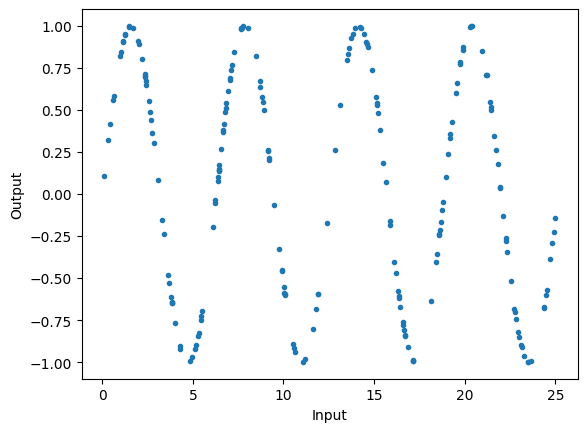

In [289]:
x_train = torch.rand(200, 1) * 25
x_train = x_train[x_train.flatten().argsort(), :]
y_train = torch.sin(x_train)
plt.plot(x_train.flatten(), y_train.flatten(), '.')
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Now we'll train a set of emulators.

In [290]:
# Training
emulators = []
for i in range(n_emulators := 4):
    torch.manual_seed(i)
    n_nodes = (i + 1) * 10
    emulator = MLPEmulator(1, 1, [n_nodes] * 3, nn.Softplus, epochs=1000)
    emulator.fit(x_train, y_train)
    emulators.append(emulator)

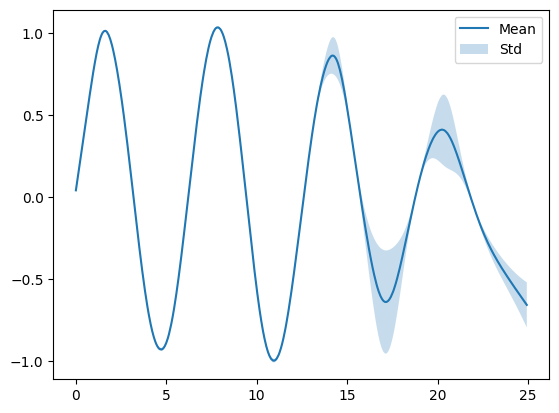

In [ ]:
# Testing
x_test = torch.rand(1000, 1) * 25
x_test = x_test[x_test.flatten().argsort(), :]
y = []
with torch.no_grad():
    for emulator in emulators:
        y.append(emulator.predict(x_test))
    y = torch.stack(y)
y_mean = y.mean(dim=0, keepdim=True)
y_centered = y - y_mean
y_mean = y_mean[0, :, :] # (n_points, n_dims)
y_cov = torch.einsum('s p d, s p e -> p d e', y_centered, y_centered) / (n_emulators - 1) # (n_points, n_dims, n_dims)

# Plot
plt.plot(x_test[:, 0], y_mean[:, 0], label='Mean')
plt.fill_between(x_test[:, 0], y_mean[:, 0] - y_cov[:, 0, 0], y_mean[:, 0] + y_cov[:, 0, 0], alpha=0.25, label='Std')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

**Ensemble**
`Emulator.predict(x)` returns `(mean, covariance)`, possibly different ones for multiple calls over a given `x` and possibly with a zero `covariance`. Let `M` be the number of emulators in the ensemble and `N` be the number of samples (calls) per emulator. Then the `(mean, covariance)` of the ensemble would be

$$
\mu_{\mathrm{ens}}
= \frac{1}{M N}
  \sum_{i=1}^{M}\sum_{j=1}^{N}
    \mu_i^{(j)},
$$
$$
\Sigma_{\mathrm{ens}}
= \frac{1}{M N}
  \sum_{i=1}^{M}\sum_{j=1}^{N}
    \Sigma_i^{(j)}
+
  \frac{1}{M N - 1}
  \sum_{i=1}^{M}\sum_{j=1}^{N}
    \bigl(\mu_i^{(j)} - \mu_{\mathrm{ens}}\bigr)
    \bigl(\mu_i^{(j)} - \mu_{\mathrm{ens}}\bigr)^{T}.
$$

where the first term of $\Sigma_{\mathrm{ens}}$ is the aleatoric uncertainty and the second is the epistemic uncertainty. One choice for the disagreement score for query-by-committee is $\mathrm{trace}(\Sigma_{\mathrm{ens}})$. This should hold up even if some of the emulators in the ensemble are ensembles themselves. Also, weights could be assigned for the summations above to place priorities on certain emulators.

In [ ]:
class Ensemble(Emulator, ValidationMixin, TorchDeviceMixin):
    """
    Ensemble emulator that aggregates multiple Emulator instances and returns
    a MultivariateNormal representing the ensemble posterior.
    Note that an Emulator instance may also be an Ensemble itself.

    Parameters
        Emulators: list[Emulator] List of fitted emulator instances. Each member's `predict(x: Tensor)` 
        must return either:
            - TensorLike (treated as mean)
            - MultivariateNormal (with `.mean` and `.covariance_matrix`)
    """

    def __init__(self, emulators: List[Emulator]):
        if not emulators:
            raise ValueError("Ensemble must contain at least one emulator.")
        self.emulators = emulators
        self.M = len(emulators)
        self.is_fitted_ = all(getattr(em, 'is_fitted_', False) for em in emulators)

    @staticmethod
    def is_multioutput() -> bool:
        return True

    @staticmethod
    def get_tune_config() -> TuneConfig:
        # No tunable hyperparameters at the ensemble level
        return {}

    def _fit(self, x: TensorLike, y: TensorLike) -> None:
        for em in self.emulators:
            em.fit(x, y)
        self.is_fitted_ = True

    def _predict(self, x: Tensor) -> torch.distributions.MultivariateNormal:
        """
        Perform inference with the ensemble.

        Inputs:
            - x of shape (batch_size, n_dims)

        Returns:
            - torch.distributions.MultivariateNormal with
                - mean of shape (batch_size, n_dims)
                - cov of shape (batch_size, n_dims, n_dims) (no inter-sample covariance)
        """
        # Inference mode to disable autograd computation graph
        with torch.inference_mode():
            device = x.device
            means: List[Tensor] = []
            covs: List[Tensor] = []

            # Outputs from each emulator
            for em in self.emulators:
                if isinstance(em, PyTorchBackend):
                    em.eval()
                out = em.predict(x)
                if isinstance(out, torch.distributions.MultivariateNormal):
                    mu_i = out.mean.to(device)
                    sigma_i = out.covariance_matrix.to(device)
                else:
                    mu_i = out.to(device)
                    dim = mu_i.shape[-1]
                    sigma_i = torch.zeros(mu_i.size(0), dim, dim, device=device)
                means.append(mu_i)
                covs.append(sigma_i)

            # Stacked means and covs
            mu_stack = torch.stack(means, dim=0) # (M, batch, dim)
            cov_stack = torch.stack(covs, dim=0) # (M, batch, dim, dim)

            # Uniform ensemble mean and aleatoric average
            # NOTE: can implement weighting in future
            mu_ens = mu_stack.mean(dim=0)       # (batch, dim)
            sigma_alea = cov_stack.mean(dim=0)   # (batch, dim, dim)

            # Epistemic covariance: unbiased over M members
            dev = mu_stack - mu_ens.unsqueeze(0)  # (M, batch, dim)
            sigma_epi = torch.einsum('m b d, m b e -> b d e', dev, dev) / (self.M - 1)

            # Total covariance
            sigma_ens = sigma_alea + sigma_epi  # (batch, dim, dim)

            # Return as MultivariateNormal
            return torch.distributions.MultivariateNormal(loc=mu_ens, covariance_matrix=sigma_ens)

In [298]:
# Ensemble
emulators = []
for i in range(n_emulators := 4):
    torch.manual_seed(i)
    n_nodes = (i + 1) * 10
    emulator = MLPEmulator(1, 1, [n_nodes] * 3, nn.Softplus, epochs=1000)
    # emulator.fit(x_train, y_train)
    emulators.append(emulator)
ensemble = Ensemble(emulators)
ensemble.fit(x_train, y_train)

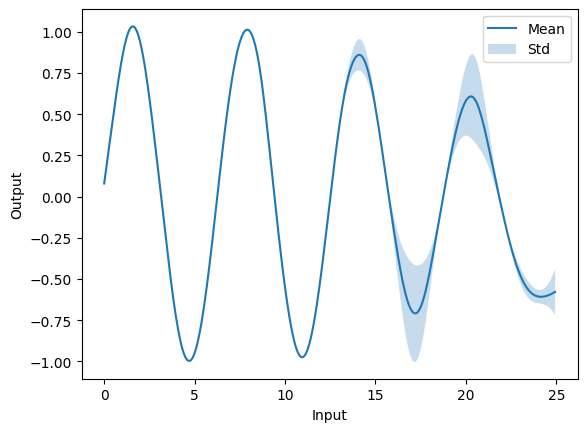

In [316]:
y = ensemble.predict(x_test)
plt.plot(x_test[:, 0], y.mean[:, 0], label='Mean')
plt.fill_between(
    x_test[:, 0], 
    y.mean[:, 0] - y.covariance_matrix[:, 0, 0], 
    y.mean[:, 0] + y.covariance_matrix[:, 0, 0],
    alpha=0.25, label='Std'
)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

## An ensemble of ensembles?

In [326]:
# An ensemble w/ 2 layer MLP emulators
emulators = []
for i in range(4):
    torch.manual_seed(i)
    n_nodes = (i + 1) * 10
    emulator = MLPEmulator(1, 1, [n_nodes] * 2, nn.Softplus, epochs=1000)
    emulators.append(emulator)
ensemble = Ensemble(emulators)

# An ensemble w/ the above ensemble and 3 layer emulators
emulators = [ensemble]
for i in range(4):
    torch.manual_seed(i)
    n_nodes = (i + 1) * 10
    emulator = MLPEmulator(1, 1, [n_nodes] * 3, nn.Softplus, epochs=1000)
    emulators.append(emulator)
ensemble = Ensemble(emulators)

# This is how it looks when we print (one is an ensemble, the other's are MLPs)
# NOTE: it would be helpful to have a special print or use dataclasses to recursively print modules
ensemble.emulators

 MLPEmulator(input_dim=1, output_dim=1, hidden_dims=[10, 10, 10], activation=<class 'torch.nn.modules.activation.Softplus'>, dropout=False, dropout_prob=0.5, lr=0.001, batch_size=16, shuffle=True, epochs=1000, verbose=False),
 MLPEmulator(input_dim=1, output_dim=1, hidden_dims=[20, 20, 20], activation=<class 'torch.nn.modules.activation.Softplus'>, dropout=False, dropout_prob=0.5, lr=0.001, batch_size=16, shuffle=True, epochs=1000, verbose=False),
 MLPEmulator(input_dim=1, output_dim=1, hidden_dims=[30, 30, 30], activation=<class 'torch.nn.modules.activation.Softplus'>, dropout=False, dropout_prob=0.5, lr=0.001, batch_size=16, shuffle=True, epochs=1000, verbose=False),
 MLPEmulator(input_dim=1, output_dim=1, hidden_dims=[40, 40, 40], activation=<class 'torch.nn.modules.activation.Softplus'>, dropout=False, dropout_prob=0.5, lr=0.001, batch_size=16, shuffle=True, epochs=1000, verbose=False)]

In [327]:
# Train everything (NOTE: would be nice to get an output of which modules are being trained)
ensemble.fit(x_train, y_train)

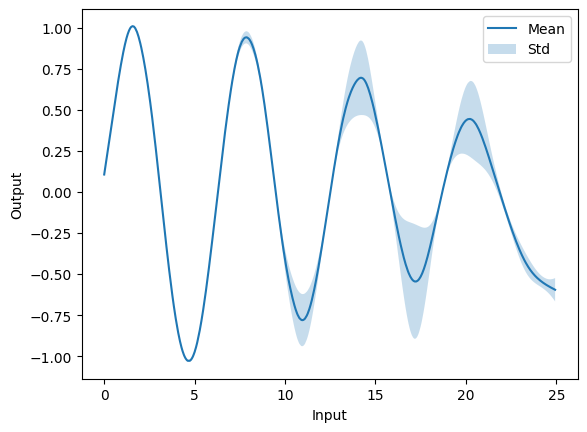

In [328]:
y = ensemble.predict(x_test)
plt.plot(x_test[:, 0], y.mean[:, 0], label='Mean')
plt.fill_between(
    x_test[:, 0], 
    y.mean[:, 0] - y.covariance_matrix[:, 0, 0], 
    y.mean[:, 0] + y.covariance_matrix[:, 0, 0],
    alpha=0.25, label='Std'
)
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()